# Read-in example of the synthesis logs with plotting

This notebook shows an example on how to read interesting informatino from the synthesis files, and plot such information.

**Note:** Expects HDF5 files (\*.h5) in directory `tests/testdata`. They can be generated by running `sh scripts/RunMultiple.sh` from the top-level source directory.

In [1]:
from pathlib import Path
import h5py
import nexusformat.nexus as nx # makes it easier to extract information. 
import numpy as np
from attrs import Factory
from attrs import define, validators, field, cmp_using, fields
import pandas as pd

import logging
from typing import Iterable
from typing import Any, NoReturn

import plotly.express as px

In [2]:
# Setting up some flexible HDF reading methods (copied from DataMerge dataclasses and readers for now): 

# Mixin class for making a dict-like object out of an attrs class
# from: https://github.com/python-attrs/attrs/issues/879

import yaml

class gimmeItems:  # used to be MutableMappingMixin(MutableMapping)
    """Mixin class to make attrs classes quack like a dictionary (well,
    technically a mutable mapping). ONLY use this with attrs classes.

    Provides keys(), values(), and items() methods in order to be
    dict-like in addition to MutableMapping-like. Also provides pop(),
    but it just raises a TypeError :)
    """

    __slots__ = ()  # May as well save on memory?

    def __iter__(self) -> Iterable:
        for ifield in fields(self.__class__):
            yield ifield.name

    def __len__(self) -> int:
        return len(fields(self.__class__))

    def __getitem__(self, k: str) -> Any:
        """
        Adapted from:
        https://github.com/python-attrs/attrs/issues/487#issuecomment-660727537
        """
        try:
            return self.__getattribute__(k)
        except AttributeError as exc:
            raise KeyError(str(exc)) from None

    def __delitem__(self, v: str) -> NoReturn:
        raise TypeError("Cannot delete fields for attrs classes.")

    def __setitem__(self, k: str, v: Any) -> None:
        self.__setattr__(k, v)

    def pop(self, key, default=None) -> NoReturn:
        raise TypeError("Cannot pop fields from attrs classes.")

    def keys(self) -> Iterable:
        return self.__iter__()

    def values(self) -> Iterable:
        for key in self.__iter__():
            yield self.__getattribute__(key)

    def items(self) -> Iterable:
        for key in self.__iter__():
            yield key, self.__getattribute__(key)

# end copy

# First, we set the read names and locations here:
@define
class HDFPathsObj(gimmeItems):
    """
    Config carrying the HDF5 path locations for reading datafiles.
    """

    # Q: str = field(
    #     default="/entry/result/Q", validator=validators.instance_of(str), converter=str
    # )
    # I: str = field(
    #     default="/entry/result/I", validator=validators.instance_of(str), converter=str
    # )
    # ISigma: str = field(
    #     default="/entry/result/ISigma",
    #     validator=validators.instance_of(str),
    #     converter=str,
    # )
    SampleID: str = field(
        default="/DACHS/Synthesis/RawLog/0/SampleID", # hdf5 location
        validator=validators.instance_of(str), # locations are in string format
        converter=str,
    )
    ExperimentID: str = field(
        default="/DACHS/Synthesis/RawLog/0/ExperimentID",
        validator=validators.instance_of(str),
        converter=str,
    )    
    InjectionSpeed: str = field(
        default="/DACHS/Synthesis/DerivedParameters/InjectionSpeed", # hdf5 location
        validator=validators.instance_of(str), # locations are in string format
        converter=str,
    )
    # not able to read attributes yet
    # InjectionSpeedUnits: str = field(
    #     default="/AutoMOF5/MOF_synthesis_1/KeyParameters/InjectionSpeed",
    #     validator=validators.instance_of(str),
    #     converter=str,
    # )
    MetalToLinkerRatio: str = field(
        default="/DACHS/Synthesis/DerivedParameters/MetalToLinkerRatio", # hdf5 location
        validator=validators.instance_of(str), # locations are in string format
        converter=str,
    )
    MetalToMethanolRatio: str = field(
        default="/DACHS/Synthesis/DerivedParameters/MetalToMethanolRatio",
        validator=validators.instance_of(str),
        converter=str,
    )
    ReactionTime: str = field(
        default="/DACHS/Synthesis/DerivedParameters/ReactionTime",
        validator=validators.instance_of(str),
        converter=str,
    )    
    SynthesisYield: str = field(
        default="/DACHS/Chemicals/SynthesisYield",
        validator=validators.instance_of(str),
        converter=str,
    )

# then we configure the defaults for the same: 
@define
class HDFDefaultsObj(gimmeItems):
    """In case the preset HDF5 paths are empty, defaults can be used for some non-critical items"""

    SampleID: str = field(
        default="", validator=validators.instance_of(str), converter=str
    )
    ExperimentID: str = field(
        default="", validator=validators.instance_of(str), converter=str
    )
    # I guess these should be pint Units at some point. 
    InjectionSpeed: float = field(
        default=0.0, # hdf5 location
        validator=validators.instance_of(float), # locations are in string format
        converter=float,
    )
    MetalToLinkerRatio: float = field(
        default=0.0, # hdf5 location
        validator=validators.instance_of(float), # locations are in string format
        converter=float,
    )
    MetalToMethanolRatio: float = field(
        default=0.0, # hdf5 location
        validator=validators.instance_of(float), # locations are in string format
        converter=float,
    )
    ReactionTime: float = field(
        default=0.0, # hdf5 location
        validator=validators.instance_of(float), # locations are in string format
        converter=float,
    )
    SynthesisYield: float = field(
        default=0.0, # hdf5 location
        validator=validators.instance_of(float), # locations are in string format
        converter=float,
    )


@define
class readConfigObj(gimmeItems):
    """
    Object that carries information on how to read the datafiles
    """

    hdfPaths: HDFPathsObj = field(
        default=Factory(HDFPathsObj),
        validator=validators.instance_of(HDFPathsObj),
    )

    hdfDefaults: HDFDefaultsObj = field(
        default=Factory(HDFDefaultsObj),
        validator=validators.instance_of(HDFDefaultsObj),
    )

# this could be used to read the configuration from yaml files: 
def readConfigObjFromYaml(filename: Path) -> readConfigObj:
    assert (
        filename.is_file()
    ), f"Read configuration filename {filename.as_posix()} does not exist"
    with open(filename, "r") as f:
        configDict = yaml.safe_load(f)
    if "readConfig" not in configDict.keys():
        return readConfigObj(HDFPathsObj(), HDFDefaultsObj())
    print(configDict["readConfig"])
    HDFPaths = HDFPathsObj(**configDict["readConfig"].get("HDFPaths", {}))
    HDFDefaults = HDFDefaultsObj(**configDict["readConfig"].get("HDFDefaults", {}))
    return readConfigObj(HDFPaths, HDFDefaults)


# now for the actual reader, modified here slightly to output to Pandas Dataframe:
def scatteringDataObjFromNX(
    filename: Path, readConfig: readConfigObj
) -> pd.DataFrame:
    """Returns a populated scatteringDataObj by reading the data from a Processed MOUSE NeXus file"""
    assert filename.is_file(), logging.warning(
        f'{filename=} cannot be accessed from {Path(".").absolute().as_posix()}'
    )
    with h5py.File(filename, "r") as h5f:
        kvs = {}
        for key in readConfig.hdfPaths.keys():
            hPath = getattr(readConfig.hdfPaths, key)
            #print(f"{key=}, {hPath=}")
            if hPath in h5f:
                val = h5f[hPath]
                #print(f"  {val=}", type(val))
                try:
                    val = val[()]  # access the scalar value of a dataset
                except TypeError:
                    val = val["Quantity"]
                    val = val[()]  # access the scalar value of a dataset, 2nd try
                if isinstance(val, np.ndarray):
                    val = val.flatten()
            else:
                assert key in readConfig.hdfDefaults.keys(), logging.error(
                    f"NeXus file {filename=} does not contain information for {key=} at specified HDF5 Path {hPath}"
                )
                val = getattr(readConfig.hdfDefaults, key)
            if isinstance(val, bytes): val=val.decode('utf-8')
            kvs.update({key: val})

    return pd.DataFrame(data=kvs, index=[0])

In [3]:
filesH5 = list((Path().resolve().parent / 'tests/testData/').glob('*AutoMOFs*.h5'))
if not len(filesH5):
    raise Warning("No HDF5 archive files found, ie. generated yet!")
[fn.name for fn in filesH5]

['log_AutoMOFs_6_L019.h5']

In [4]:
iList = []
for filename in filesH5:
    iList += [scatteringDataObjFromNX(filename, readConfigObj())]
info = pd.concat(iList, axis=0, ignore_index=True)
info['SampleID'] = info['SampleID'].str.strip()
info['ReactionType'] = info['SampleID'].str[:1]
info

,SampleID,ExperimentID,InjectionSpeed,MetalToLinkerRatio,MetalToMethanolRatio,ReactionTime,SynthesisYield,ReactionType
0,L019,AutoMOFs_6,40.0,6.332672,483.489282,1245.0,0.201838,L


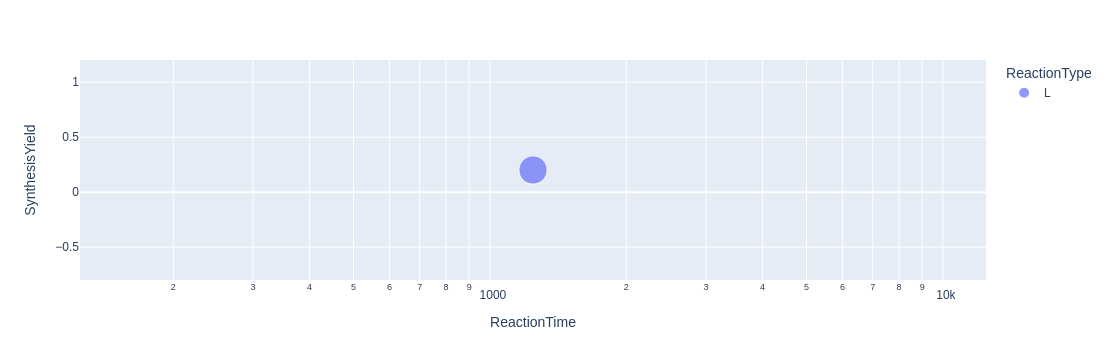

In [5]:
fig=px.scatter(data_frame=info, x='ReactionTime', y='SynthesisYield', color='ReactionType', size='MetalToLinkerRatio', hover_data=info.keys(), log_x=True)
fig.show()

In [6]:
# This is the demo from the website, modified slightly to use jupyter_dash

from dash import Dash, html, dcc, Input, Output
#from jupyter_dash import JupyterDash
import pandas as pd
import plotly.express as px

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = Dash(__name__, external_stylesheets=external_stylesheets)

df = info # pd.read_csv('https://plotly.github.io/datasets/country_indicators.csv')


app.layout = html.Div([
    html.Div([

        html.Div([
            dcc.Dropdown(
                df.keys().unique(),
                'ReactionTime',
                id='crossfilter-xaxis-column',
            ),
            dcc.RadioItems(
                ['Linear', 'Log'],
                'Linear',
                id='crossfilter-xaxis-type',
                labelStyle={'display': 'inline-block', 'marginTop': '5px'}
            )
        ],
        style={'width': '49%', 'display': 'inline-block'}),

        html.Div([
            dcc.Dropdown(
                df.keys().unique(),
                'SynthesisYield',
                id='crossfilter-yaxis-column'
            ),
            dcc.RadioItems(
                ['Linear', 'Log'],
                'Linear',
                id='crossfilter-yaxis-type',
                labelStyle={'display': 'inline-block', 'marginTop': '5px'}
            )
        ], style={'width': '49%', 'float': 'right', 'display': 'inline-block'})
    ], style={
        'padding': '10px 5px'
    }),

    html.Div([
        dcc.Graph(
            id='crossfilter-indicator-scatter',
            hoverData={'points': [{'customdata': 'Japan'}]}
        )
    ], style={'width': '80%', 'display': 'inline-block', 'padding': '0 20'}),
    # html.Div([
    #     dcc.Graph(id='x-time-series'),
    #     dcc.Graph(id='y-time-series'),
    # ], style={'display': 'inline-block', 'width': '49%'}),

    # html.Div(dcc.Slider(
    #     df['MetalToLinkerRatio'].min(),
    #     df['MetalToLinkerRatio'].max(),
    #     step=None,
    #     id='crossfilter-year--slider',
    #     value=df['MetalToLinkerRatio'].max(),
    #     marks={str(MetalToLinkerRatio): str(MetalToLinkerRatio) for MetalToLinkerRatio in df['MetalToLinkerRatio'].unique()}
    # ), style={'width': '49%', 'padding': '0px 20px 20px 20px'})
])


@app.callback(
    Output('crossfilter-indicator-scatter', 'figure'),
    Input('crossfilter-xaxis-column', 'value'),
    Input('crossfilter-yaxis-column', 'value'),
    Input('crossfilter-xaxis-type', 'value'),
    Input('crossfilter-yaxis-type', 'value'),
    # Input('crossfilter-year--slider', 'value')
    )

def update_graph(xaxis_column_name, yaxis_column_name,
                 xaxis_type, yaxis_type,
                 ):
    # dff = df[df['MetalToLinkerRatio'] == year_value]
    dff = df
    fig = px.scatter(data_frame=dff, x=xaxis_column_name,
            y=yaxis_column_name,
            color='ReactionType',
            size='MetalToLinkerRatio',
            hover_data=dff.keys(),
            hover_name='SampleID', # dff[yaxis_column_name]
            )
    
    # fig=px.scatter(data_frame=info, x='ReactionTime', y='SynthesisYield', color='ReactionType', size='MetalToLinkerRatio', hover_data=info.keys(), log_x=True)

    fig.update_traces(customdata=dff) # [yaxis_column_name])

    fig.update_xaxes(title=xaxis_column_name, type='linear' if xaxis_type == 'Linear' else 'log')

    fig.update_yaxes(title=yaxis_column_name, type='linear' if yaxis_type == 'Linear' else 'log')

    fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')

    return fig


# def create_time_series(dff, axis_type, title):

#     fig = px.scatter(dff, x='MetalToLinkerRatio', y='MetalToLinkerRatio')

#     fig.update_traces(mode='lines+markers')

#     fig.update_xaxes(showgrid=False)

#     fig.update_yaxes(type='linear' if axis_type == 'Linear' else 'log')

#     fig.add_annotation(x=0, y=0.85, xanchor='left', yanchor='bottom',
#                        xref='paper', yref='paper', showarrow=False, align='left',
#                        text=title)

#     fig.update_layout(height=225, margin={'l': 20, 'b': 30, 'r': 10, 't': 10})

#     return fig


# @app.callback(
#     Output('x-time-series', 'figure'),
#     Input('crossfilter-indicator-scatter', 'hoverData'),
#     Input('crossfilter-xaxis-column', 'value'),
#     Input('crossfilter-xaxis-type', 'value'))
# def update_y_timeseries(hoverData, xaxis_column_name, axis_type):
#     country_name = hoverData['points'][0]['customdata']
#     dff = df[df['MetalToLinkerRatio'] == country_name]
#     dff = dff[dff['MetalToLinkerRatio'] == xaxis_column_name]
#     title = '<b>{}</b><br>{}'.format(country_name, xaxis_column_name)
#     return create_time_series(dff, axis_type, title)


# @app.callback(
#     Output('y-time-series', 'figure'),
#     Input('crossfilter-indicator-scatter', 'hoverData'),
#     Input('crossfilter-yaxis-column', 'value'),
#     Input('crossfilter-yaxis-type', 'value'))
# def update_x_timeseries(hoverData, yaxis_column_name, axis_type):
#     dff = df[df['MetalToLinkerRatio'] == hoverData['points'][0]['customdata']]
#     dff = dff[dff['MetalToLinkerRatio'] == yaxis_column_name]
#     return create_time_series(dff, axis_type, yaxis_column_name)


if __name__ == '__main__':
    app.run(jupyter_mode='external')#, debug=True)

Dash app running on http://127.0.0.1:8050/
